In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv('E:\chatbot-01\datasets\hr\heart_rate_data.csv')

# Convert 'date' and 'time' to a single 'datetime' column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Drop the original 'date' and 'time' columns
df.drop(['date', 'time'], axis=1, inplace=True)

# Sort by datetime (ensures the time series is ordered)
df = df.sort_values('datetime').reset_index(drop=True)

# Scaling the bpm data
scaler = MinMaxScaler()
df['bpm_scaled'] = scaler.fit_transform(df[['bpm']])

# Create sequences for time series (window size can be tuned)
def create_sequences_with_datetime(data, window_size):
    sequences = []
    datetime_seq = []
    for i in range(len(data) - window_size):
        seq = data['bpm_scaled'].values[i:i + window_size]
        seq_datetime = data['datetime'].values[i:i + window_size]  # Capture corresponding datetime
        sequences.append(seq)
        datetime_seq.append(seq_datetime)
    return np.array(sequences), np.array(datetime_seq)

# Set the window size for the time series
window_size = 15  # Example: 25 timesteps
sequences, datetime_seq = create_sequences_with_datetime(df, window_size)

# Split sequences into input (X) and target (y)
X = sequences[:, :-1]
y = sequences[:, -1]

# Check what is being passed as the features (input data)
print("First 5 sequences (features) being fed to the model:")
print(X[:5])  # View the first 5 sequences of bpm_scaled
print("\nCorresponding datetime values:")
print(datetime_seq[:5])  # View the corresponding datetime values for each sequence

# Prepare the data for feeding into the model (reshaping)
X_reshaped = np.expand_dims(X, axis=-1)  # Reshape to (samples, timesteps, features)

# Check the shape of the reshaped data
print("Shape of input data (samples, timesteps, features):", X_reshaped.shape)


(14, 1)


c:\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


c:\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch: 0 [D loss: 0.6965270042419434, acc.: 17.19%] [G loss: [array(0.69540006, dtype=float32), array(0.69540006, dtype=float32), array(0.28125, dtype=float32)]]
Evaluation: MSE: 0.0689, MAE: 0.2372, Correlation: 0.3034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━

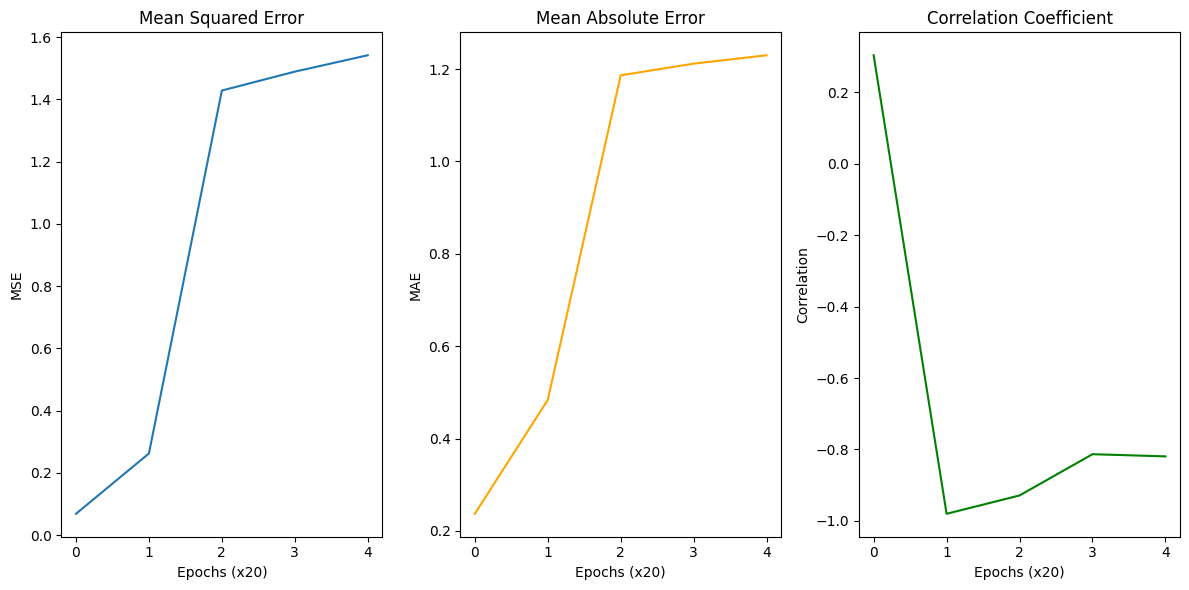

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Generator Model
def build_generator(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(layers.Dropout(0.2))  # Regularization to prevent overfitting
    model.add(layers.LSTM(64))
    model.add(layers.Dense(1, activation='tanh'))
    return model

# Discriminator Model
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(layers.Dropout(0.32))
    model.add(layers.LSTM(64))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Prepare data for the model
X_reshaped = np.expand_dims(X, axis=-1)  # Reshape to (samples, timesteps, features)

# Define input shape for the model
input_shape = (window_size - 1, 1)  # (timesteps, features)
print(input_shape)

# Build and compile models
generator = build_generator(input_shape)
discriminator = build_discriminator(input_shape)

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# GAN Model (combining generator and discriminator)
discriminator.trainable = False  # Freeze discriminator while training the GAN
gan_input = layers.Input(shape=(window_size - 1, 1))
generated_data = generator(gan_input)
validity = discriminator(generated_data)
gan = models.Model(gan_input, validity)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Training setup
epochs = 100
batch_size = 32

real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# Lists to track metrics during training
mse_history = []
mae_history = []
corr_history = []

# Training loop
for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, X_reshaped.shape[0], batch_size)
    real_data = X_reshaped[idx]  # Get real data batch (bpm_scaled sequences)
    real_labels = y[idx]  # Ground truth target values for real data
    
    # Generate fake data using the generator
    generated_data = generator.predict(real_data)

    # Train the discriminator on real and generated data
    d_loss_real = discriminator.train_on_batch(real_data, real)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train Generator (through GAN)
    g_loss = gan.train_on_batch(real_data, real)

    # Evaluate generated data with MSE, MAE, and correlation every few epochs
    if epoch % 20 == 0:
        predicted_bpm = generator.predict(real_data)
        real_bpm = real_labels  # The ground truth BPM values
        
        mse = mean_squared_error(real_bpm, predicted_bpm)
        mae = mean_absolute_error(real_bpm, predicted_bpm)
        corr = np.corrcoef(real_bpm.flatten(), predicted_bpm.flatten())[0, 1]

        mse_history.append(mse)
        mae_history.append(mae)
        corr_history.append(corr)

        # Print the progress and metrics
        print(f"Epoch: {epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss}]")
        print(f"Evaluation: MSE: {mse:.4f}, MAE: {mae:.4f}, Correlation: {corr:.4f}")

# Save the trained generator model
# generator.save('heart_rate_generator_model.h5')

# Plot the evaluation metrics over time
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 3, 1)
plt.plot(mse_history, label='MSE')
plt.title('Mean Squared Error')
plt.xlabel('Epochs (x20)')
plt.ylabel('MSE')

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(mae_history, label='MAE', color='orange')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs (x20)')
plt.ylabel('MAE')

# Plot Correlation
plt.subplot(1, 3, 3)
plt.plot(corr_history, label='Correlation', color='green')
plt.title('Correlation Coefficient')
plt.xlabel('Epochs (x20)')
plt.ylabel('Correlation')

plt.tight_layout()
plt.show()
